# Model Performance vs Cohort Window (K)

This notebook aggregates every all_metrics*.csv artifact inside the results/ tree (plus the standalone *_results.csv summaries) so we can analyze how each model behaves as the cohort size K changes.

It builds a consolidated dataframe and helper plotting utilities for inspecting accuracy, precision, recall, F1, and AUC trends across models.


## Workflow

1. Locate the canonical results/ directory relative to this notebook.
2. Discover metric CSVs, normalize their schemas, and concatenate them into a single table.
3. Produce aggregated statistics and visualize model performance as a function of the cohort window K.

> The notebook expects common data-science dependencies (pandas, matplotlib, seaborn) to be available in the active kernel.


In [24]:
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option("display.max_rows", 10)
pd.set_option("display.float_format", "{:.4f}".format)


In [25]:
def find_results_dir(start: Path) -> Path:
    """Walk upward from the starting directory until we find the results folder."""
    for current in [start] + list(start.parents):
        candidate = current / "results"
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"Could not locate a results/ directory from {start}")

RESULTS_DIR = find_results_dir(Path.cwd())
REPO_ROOT = RESULTS_DIR.parent
print(f"Using results directory: {RESULTS_DIR}")

MODEL_NAME_OVERRIDES = {
    "logistic_regression": "Logistic Regression",
    "random_forest": "Random Forest",
    "xgboost": "XGBoost",
    "graph_features_baseline": "Graph Features Baseline",
    "graph_features": "Graph Features Baseline",
    "evolve_gcn_multi_seed": "Temporal GCN (EvolveGCN)",
    "static_gcn_multi_seed": "Static GCN (Multi-Seed)",
    "static_gcn_results": "Static GCN (Single Run)",
    "temporal_gcn_results": "Temporal GCN (Single Run)",
    "all_models_comparison": "Temporal vs Static GCN",
}

EXTRA_RESULT_FILES = [
    RESULTS_DIR / "all_models_comparison.csv",
    RESULTS_DIR / "temporal_gcn_results.csv",
    RESULTS_DIR / "static_gcn_results.csv",
    RESULTS_DIR / "comprehensive_gnn_comparison_with_timing.csv",
]

METRIC_COLUMN_CANDIDATES = ["accuracy", "precision", "recall", "f1", "auc"]

def infer_model_name(path: Path) -> str:
    """Derive a human-friendly model label from the file path."""
    candidates = [path.stem, path.parent.name]
    candidates.extend(part for part in path.parts if part not in {"results", "baselines"})
    for candidate in candidates:
        key = candidate.lower().replace(".csv", "")
        if key in MODEL_NAME_OVERRIDES:
            return MODEL_NAME_OVERRIDES[key]
    raw = path.parent.name if path.parent.name.lower() not in {"results", "baselines"} else path.stem
    return raw.replace("_", " " ).title()

def discover_metric_files(results_dir: Path) -> List[Path]:
    metric_paths = sorted(results_dir.rglob("*all_metrics*.csv"))
    for extra in EXTRA_RESULT_FILES:
        if extra.exists():
            metric_paths.append(extra)
    unique_paths, seen = [], set()
    for path in metric_paths:
        resolved = path.resolve()
        if resolved not in seen:
            seen.add(resolved)
            unique_paths.append(path)
    return unique_paths

def normalize_split_label(value: str) -> str:
    if not isinstance(value, str):
        return "test"
    normalized = value.strip().lower()
    return {"validation": "val", "valid": "val"}.get(normalized, normalized)

def expand_prefixed_metrics(df: pd.DataFrame) -> pd.DataFrame:
    prefixes = ["train", "val", "test"]
    has_prefixed = any(
        col.startswith(f"{prefix}_")
        for prefix in prefixes
        for col in df.columns
    )
    if not has_prefixed:
        return df
    frames = []
    for prefix in prefixes:
        metric_columns = {
            metric: f"{prefix}_{metric}"
            for metric in METRIC_COLUMN_CANDIDATES
            if f"{prefix}_{metric}" in df.columns
        }
        if not metric_columns:
            continue
        base_cols = [name for name in ["model", "seed", "k"] if name in df.columns]
        cols = base_cols + list(metric_columns.values())
        subset = df[cols].copy()
        subset = subset.rename(columns={v: metric for metric, v in metric_columns.items()})
        subset["split"] = prefix
        frames.append(subset)
    return pd.concat(frames, ignore_index=True) if frames else df

def load_metrics_frame(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [col.strip().lower() for col in df.columns]
    df = expand_prefixed_metrics(df)
    if "k" not in df.columns:
        raise ValueError(f"Expected a 'K' column inside {path}")
    df = df.rename(columns={"k": "K"})
    numeric_columns = set(METRIC_COLUMN_CANDIDATES + ["K", "seed"])
    for column in numeric_columns:
        if column in df.columns:
            df[column] = pd.to_numeric(df[column], errors="coerce")
    if "split" in df.columns:
        df["split"] = df["split"].apply(normalize_split_label)
    else:
        df["split"] = "test"
    if "model" not in df.columns or df["model"].isna().all():
        df["model"] = infer_model_name(path)
    df["model"] = df["model"].astype(str)
    if "seed" in df.columns:
        df["seed"] = df["seed"].astype("Int64")
    df["K"] = df["K"].astype("Int64")
    try:
        df["source"] = path.relative_to(REPO_ROOT).as_posix()
    except ValueError:
        df["source"] = path.as_posix()
    ordered_cols = ["model", "K", "split", "seed"] + METRIC_COLUMN_CANDIDATES + ["source"]
    existing_cols = [col for col in ordered_cols if col in df.columns]
    remaining_cols = [col for col in df.columns if col not in existing_cols]
    return df[existing_cols + remaining_cols].copy()


Using results directory: c:\Users\luket\Documents\Fork\graph_ml\results


In [33]:
metric_files = discover_metric_files(RESULTS_DIR)
if not metric_files:
    raise RuntimeError("No metric files were found under the results directory.")
print(f"Discovered {len(metric_files)} metric files:")
for path in metric_files:
    print(" -", path.relative_to(REPO_ROOT))

metrics_frames = [load_metrics_frame(path) for path in metric_files]
metrics_df = (
    pd.concat(metrics_frames, ignore_index=True)
    .sort_values(["model", "split", "K", "seed"], na_position="last")
    .reset_index(drop=True)
)
metrics_df.head()


Discovered 11 metric files:
 - results\baselines\logistic_regression\all_metrics.csv
 - results\baselines\random_forest\all_metrics.csv
 - results\baselines\xgboost\all_metrics.csv
 - results\evolve_gcn_multi_seed\all_seeds_all_metrics.csv
 - results\evolve_gcn_scala_gpu\all_seeds_all_metrics.csv
 - results\graph_features_baseline\all_metrics.csv
 - results\static_gcn_multi_seed\all_seeds_all_metrics.csv
 - results\all_models_comparison.csv
 - results\temporal_gcn_results.csv
 - results\static_gcn_results.csv
 - results\comprehensive_gnn_comparison_with_timing.csv


,model,K,split,accuracy,precision,recall,f1,auc,source,seed
0,Evolve Gcn Scala Gpu,1,test,0.3760,0.0773,0.6206,0.1374,0.4954,results/evolve_gcn_scala_gpu/all_seeds_all_met...,42
1,Evolve Gcn Scala Gpu,1,test,0.9197,0.1429,0.0005,0.0011,0.5489,results/evolve_gcn_scala_gpu/all_seeds_all_met...,123
2,Evolve Gcn Scala Gpu,1,test,0.8994,0.0855,0.0263,0.0403,0.5454,results/evolve_gcn_scala_gpu/all_seeds_all_met...,456
3,Evolve Gcn Scala Gpu,3,test,0.9200,0.7000,0.0019,0.0038,0.5509,results/evolve_gcn_scala_gpu/all_seeds_all_met...,42
4,Evolve Gcn Scala Gpu,3,test,0.4160,0.1115,0.9025,0.1985,0.6341,results/evolve_gcn_scala_gpu/all_seeds_all_met...,123


In [43]:
SELECTED_MODELS = [
    "Static GCN (Multi-Seed)",
    "Temporal GCN (EvolveGCN)",
    "Evolve Gcn Scala Gpu",
    "GCN + Sampling [25, 10]"

]

if SELECTED_MODELS:
    desired = {name.lower() for name in SELECTED_MODELS}
    filtered = metrics_df[metrics_df["model"].str.lower().isin(desired)].copy()
    if filtered.empty:
        raise ValueError(f"No rows matched SELECTED_MODELS={SELECTED_MODELS}")
    print(
        f"Restricted to {filtered['model'].nunique()} models / {len(filtered)} rows."
    )
    metrics_df = filtered
else:
    print("SELECTED_MODELS is empty -> using every model.")


Restricted to 4 models / 116 rows.


## Model & Split Coverage

Use this table to see how many distinct K values are available for each (model, split) pair.


In [45]:
coverage = (
    metrics_df.dropna(subset=["K"])
    .groupby(["model", "split"])["K"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)
coverage


split,test,train,val
model,,,
Evolve Gcn Scala Gpu,4,4,4
"GCN + Sampling [25, 10]",4,0,4
Static GCN (Multi-Seed),4,4,4
Temporal GCN (EvolveGCN),4,4,4


## Aggregated Statistics

We compute per-model, per-split statistics (mean/std/count) for each metric at every K value.


In [46]:
METRIC_COLUMNS = [col for col in METRIC_COLUMN_CANDIDATES if col in metrics_df.columns]
if not METRIC_COLUMNS:
    raise ValueError("No metric columns available after loading the CSV files.")
summary_aggs = {metric: ["mean", "std", "count"] for metric in METRIC_COLUMNS}
grouped_stats = (
    metrics_df
    .dropna(subset=["K"])
    .groupby(["model", "split", "K"], as_index=False)
    .agg(summary_aggs)
)
flat_columns = []
for column in grouped_stats.columns:
    if isinstance(column, tuple):
        base, stat = column
        flat_columns.append(base if not stat else f"{base}_{stat}")
    else:
        flat_columns.append(column)
grouped_stats.columns = flat_columns
grouped_stats.head()


,model,split,K,accuracy_mean,accuracy_std,accuracy_count,precision_mean,precision_std,precision_count,recall_mean,recall_std,recall_count,f1_mean,f1_std,f1_count,auc_mean,auc_std,auc_count
0,Evolve Gcn Scala Gpu,test,1,0.7317,0.3082,3,0.1019,0.0357,3,0.2158,0.3508,3,0.0596,0.0702,3,0.5299,0.0300,3
1,Evolve Gcn Scala Gpu,test,3,0.6614,0.2522,3,0.2915,0.3546,3,0.3830,0.4660,3,0.1009,0.0973,3,0.5592,0.0711,3
2,Evolve Gcn Scala Gpu,test,5,0.2755,0.3087,3,0.0810,0.0031,3,0.7669,0.3486,3,0.1434,0.0057,3,0.4984,0.0371,3
3,Evolve Gcn Scala Gpu,test,7,0.9159,0.0040,3,0.1329,0.0828,3,0.0133,0.0174,3,0.0232,0.0292,3,0.5419,0.0072,3
4,Evolve Gcn Scala Gpu,train,1,0.7134,0.3733,3,0.0591,0.0291,3,0.2023,0.3432,3,0.0367,0.0521,3,0.5514,0.1094,3


## Plotting Helper

Call plot_metric_vs_k to visualize any available metric for a specific data split (for example, test or val).


In [47]:
def plot_metric_vs_k(metric: str = "f1", split: str = "test") -> None:
    metric = metric.lower()
    split = split.lower()
    if metric not in METRIC_COLUMNS:
        raise ValueError(f"Metric '{metric}' is not available; choose from {METRIC_COLUMNS}.")
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std" if f"{metric}_std" in grouped_stats.columns else None
    plot_df = grouped_stats[grouped_stats["split"] == split]
    if plot_df.empty:
        print(f"No rows found for split='{split}'.")
        return
    plt.figure(figsize=(10, 5))
    for model, frame in plot_df.groupby("model"):
        ordered = frame.sort_values("K")
        plt.plot(ordered["K"], ordered[mean_col], marker="o", label=model)
        if std_col and ordered[std_col].notna().any():
            lower = ordered[mean_col] - ordered[std_col]
            upper = ordered[mean_col] + ordered[std_col]
            plt.fill_between(ordered["K"], lower, upper, alpha=0.15)
    plt.xlabel("K (cohort window)")
    plt.ylabel(f"{metric.upper()} (mean ± std)")
    plt.title(f"Model performance vs K · split={split}")
    plt.xticks(sorted(plot_df["K"].dropna().unique()))
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


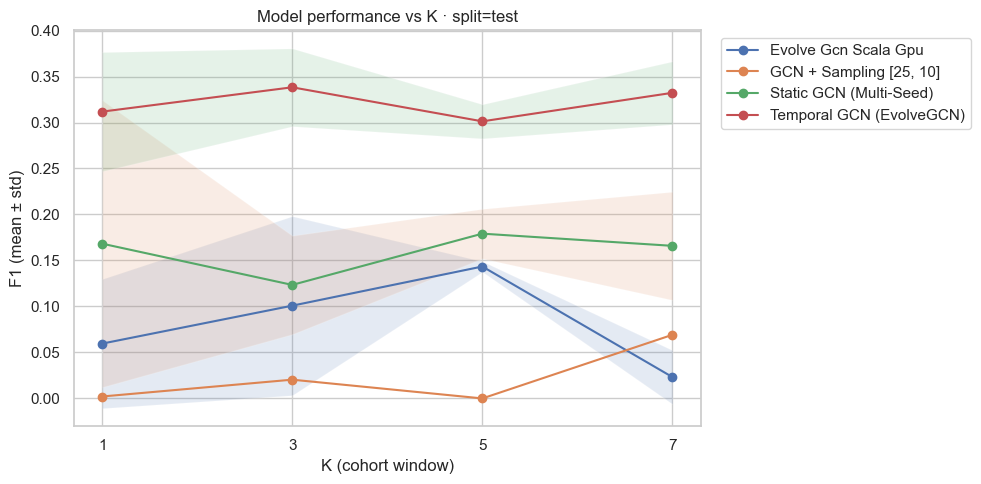

In [48]:
# Example: test F1 curves across models
plot_metric_vs_k(metric="f1", split="test")


## Focused Comparison: Static vs Temporal GCN

The cells below keep the current model filter (Static GCN (Multi-Seed) and Temporal GCN (EvolveGCN) by default) and highlight how each metric evolves with the cohort window .


In [49]:
display_metrics = ["precision", "recall", "f1", "auc"]
summary_columns = ["model", "K"] + [
    f"{metric}_mean"
    for metric in display_metrics
    if f"{metric}_mean" in grouped_stats.columns
]
comparison_table = (
    grouped_stats[grouped_stats["split"] == "test"][summary_columns]
    .sort_values(["model", "K"])
    .reset_index(drop=True)
)
comparison_table


,model,K,precision_mean,recall_mean,f1_mean,auc_mean
0,Evolve Gcn Scala Gpu,1,0.1019,0.2158,0.0596,0.5299
1,Evolve Gcn Scala Gpu,3,0.2915,0.3830,0.1009,0.5592
2,Evolve Gcn Scala Gpu,5,0.0810,0.7669,0.1434,0.4984
3,Evolve Gcn Scala Gpu,7,0.1329,0.0133,0.0232,0.5419
4,"GCN + Sampling [25, 10]",1,0.0741,0.0011,0.0021,0.5248
...,...,...,...,...,...,...
11,Static GCN (Multi-Seed),7,0.1512,0.3450,0.1659,0.5897
12,Temporal GCN (EvolveGCN),1,0.2292,0.5023,0.3118,0.7525
13,Temporal GCN (EvolveGCN),3,0.2634,0.5005,0.3383,0.7324
14,Temporal GCN (EvolveGCN),5,0.2306,0.4349,0.3013,0.6794


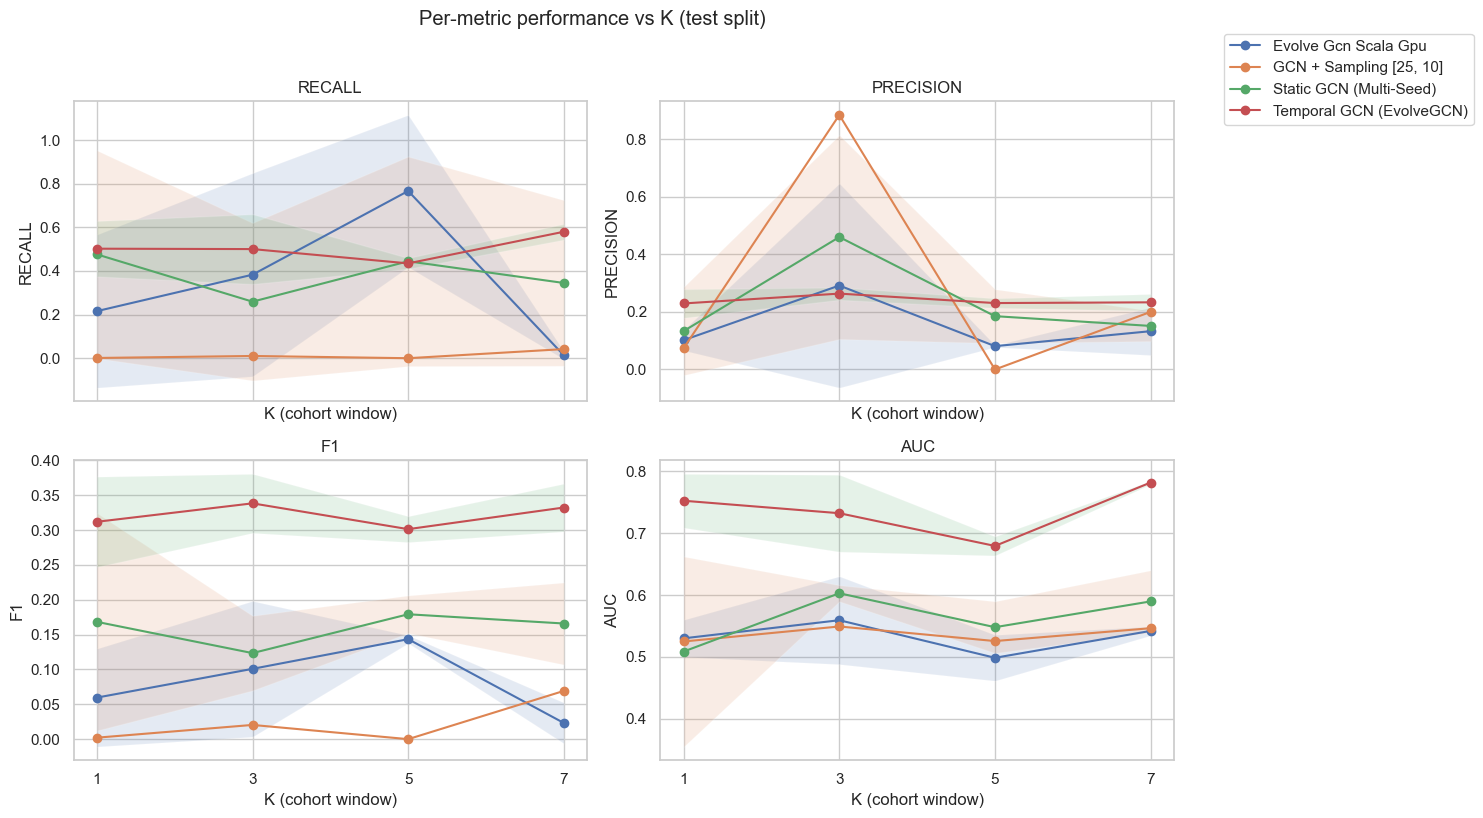

In [50]:
metrics_to_plot = ["recall", "precision", "f1", "auc"]
plot_df = grouped_stats[grouped_stats["split"] == "test"]
available_metrics = [m for m in metrics_to_plot if f"{m}_mean" in plot_df.columns]
if not available_metrics:
    raise ValueError("No metrics available for plotting.")
n_cols = 2
n_rows = (len(available_metrics) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=True)
axes = axes.flatten() if hasattr(axes, "flatten") else [axes]
for extra_ax in axes[len(available_metrics):]:
    extra_ax.set_visible(False)
for ax, metric in zip(axes, available_metrics):
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std" if f"{metric}_std" in plot_df.columns else None
    for model, frame in plot_df.groupby("model"):
        ordered = frame.sort_values("K")
        ax.plot(ordered["K"], ordered[mean_col], marker="o", label=model)
        if std_col and ordered[std_col].notna().any():
            ax.fill_between(
                ordered["K"],
                ordered[mean_col] - ordered[std_col],
                ordered[mean_col] + ordered[std_col],
                alpha=0.15,
            )
    ax.set_title(metric.upper())
    ax.set_xlabel("K (cohort window)")
    ax.set_ylabel(metric.upper())
    ax.set_xticks(sorted(plot_df["K"].dropna().unique()))
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left")
fig.suptitle("Per-metric performance vs K (test split)", y=1.02)
plt.tight_layout()
plt.show()


## Early Detection Emphasis

Recall at the smallest  values acts as a proxy for how quickly each model surfaces illicit nodes. The chart below focuses on those early windows, followed by a textual summary of the same numbers.


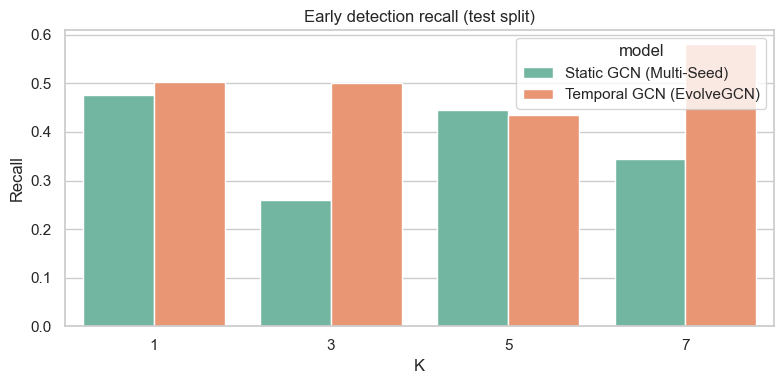

In [11]:
early_k = [k for k in sorted(plot_df["K"].dropna().unique())]
if not early_k:
    early_k = sorted(plot_df["K"].dropna().unique())[:2]
early_df = plot_df[plot_df["K"].isin(early_k)]
if early_df.empty:
    raise ValueError("No rows available for the selected early K values.")
plt.figure(figsize=(8, 4))
sns.barplot(
    data=early_df,
    x="K",
    y="recall_mean",
    hue="model",
    palette="Set2",
)
plt.title("Early detection recall (test split)")
plt.ylabel("Recall")
plt.tight_layout()
plt.show()


In [12]:
def summarize_detection(metric: str = "recall", split: str = "test", early_k_values=(1, 3)) -> None:
    subset = grouped_stats[grouped_stats["split"] == split]
    mean_col = f"{metric}_mean"
    if mean_col not in subset.columns:
        raise ValueError(f"Metric '{metric}' is unavailable in grouped_stats.")
    available_k = sorted(subset["K"].dropna().unique())
    requested_k = [k for k in early_k_values if k in available_k]
    if not requested_k:
        requested_k = available_k[: min(3, len(available_k))]
    header = f"Early detection {metric.upper()} (split={split})"
    print(header)
    print("-" * len(header))
    for model, frame in subset.groupby("model"):
        stats = []
        for k in requested_k:
            value = frame.loc[frame["K"] == k, mean_col]
            if value.empty:
                continue
            stats.append(f"K={k}: {value.iloc[0]:.3f}")
        if stats:
            print(f"- {model}: 	" + ", 	".join(stats))
summarize_detection(metric="recall", split="test")


Early detection RECALL (split=test)
-----------------------------------
- Static GCN (Multi-Seed): 	K=1: 0.476, 	K=3: 0.259
- Temporal GCN (EvolveGCN): 	K=1: 0.502, 	K=3: 0.500


In [54]:
import pandas as pd
from pathlib import Path

BASE_PATH = Path('../../results/evolve_gcn_multi_seed/all_seeds_all_metrics.csv')
SCALA_PATH = Path('../../results/evolve_gcn_scala_gpu/all_seeds_all_metrics.csv')

assert BASE_PATH.exists() and SCALA_PATH.exists(), "Missing one of the metrics CSVs."

base = pd.read_csv(BASE_PATH)
scala = pd.read_csv(SCALA_PATH)

def summarize(df, label):
    subset = df[df['split'] == 'test']
    summary = subset.groupby('K').agg(
        f1_mean=('f1', 'mean'),
        auc_mean=('auc', 'mean'),
        f1_std=('f1', 'std'),
        auc_std=('auc', 'std')
    ).reset_index()
    summary.insert(0, 'Model', label)
    return summary

comparison = pd.concat([
    summarize(base, 'EvolveGCN'),
    summarize(scala, 'EvolveGCN (scalable)')
])
comparison

,Model,K,f1_mean,auc_mean,f1_std,auc_std
0,EvolveGCN,1,0.3118,0.7525,0.0647,0.0435
1,EvolveGCN,3,0.3383,0.7324,0.0423,0.0622
2,EvolveGCN,5,0.3013,0.6794,0.0185,0.0154
3,EvolveGCN,7,0.3323,0.7820,0.0342,0.0026
0,EvolveGCN (scalable),1,0.0596,0.5299,0.0702,0.0300
1,EvolveGCN (scalable),3,0.1009,0.5592,0.0973,0.0711
2,EvolveGCN (scalable),5,0.1434,0.4984,0.0057,0.0371
3,EvolveGCN (scalable),7,0.0232,0.5419,0.0292,0.0072
